In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")

In [2]:
train = pd.read_csv("../data/train_small.csv")
test = pd.read_csv("../data/test_fe.csv")

In [3]:
train.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target
0,1.0,0.293478,0.456790,0.223460,0.473757,0.229249,0.0
1,0.0,0.456522,0.444444,0.445748,0.258287,0.071146,0.0
2,0.0,0.750000,0.740741,0.087390,0.701657,0.608696,0.0
3,0.0,0.326087,0.345679,0.159531,0.540055,0.351779,0.0
4,0.0,0.423913,0.333333,0.234018,0.397790,0.561265,0.0


In [4]:
x_train_use, y_train_use = train.drop("target", axis = 1), train["target"]

In [5]:
#x_train_use = x_train_use.drop_duplicates().reset_index(drop=True)

In [6]:
train.shape

(556, 7)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_use, y_train_use, train_size=0.8, random_state = 42)

In [8]:
x_train.shape, y_train.shape

((444, 6), (444,))

### Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(x_train, np.array(y_train).reshape(-1,1))

LogisticRegression()

In [10]:
y_pred = lr.predict(x_train)

In [11]:
f1_score(y_train, y_pred)

0.7895878524945771

In [12]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [13]:
lr_pipeline = Pipeline([("lr", LogisticRegression(solver='saga', max_iter=5000))])
param_grid = [{"lr__C":np.linspace(0,1,10), "lr__penalty":["l1","l2", "elasticnet"]}]
grid_search = GridSearchCV(lr_pipeline, param_grid, cv = 5)

In [14]:
grid_search.fit(x_train, np.array(y_train).reshape(-1,1))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             param_grid=[{'lr__C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'lr__penalty': ['l1', 'l2', 'elasticnet']}])

In [15]:
grid_search.best_params_

{'lr__C': 1.0, 'lr__penalty': 'l1'}

In [16]:
model = grid_search.best_estimator_

In [17]:
model.fit(x_train, y_train)

Pipeline(steps=[('lr',
                 LogisticRegression(max_iter=5000, penalty='l1',
                                    solver='saga'))])

In [18]:
y_pred = model.predict(x_train)

In [19]:
f1_score(y_train, y_pred)

0.8199566160520608

In [20]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       212
         1.0       0.83      0.81      0.82       232

    accuracy                           0.81       444
   macro avg       0.81      0.81      0.81       444
weighted avg       0.81      0.81      0.81       444



In [21]:
train["target"].value_counts()

0.0    278
1.0    278
Name: target, dtype: int64

In [22]:
import seaborn as sns; sns.set_style("darkgrid")

In [23]:
def plot_confusion_matrix(title,conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    plt.savefig("../conf/"+title+".png")

<AxesSubplot:>

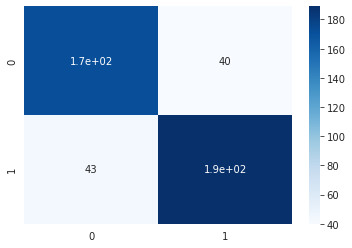

In [24]:
conf = confusion_matrix(y_train, y_pred)
sns.heatmap(conf, annot=True, cmap= "Blues")

In [25]:
y_pred_val = model.predict(x_val)

In [26]:
f1_score(y_val, y_pred_val)

0.7741935483870968

In [27]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84        66
         1.0       0.77      0.78      0.77        46

    accuracy                           0.81       112
   macro avg       0.81      0.81      0.81       112
weighted avg       0.81      0.81      0.81       112



#### Extracting results

In [28]:
import time
start = time.time()
model.fit(x_train_use, y_train_use)
elapsed = time.time() - start

In [29]:
pred_use = model.predict(x_train_use)

In [30]:
cross_val_score(model, x_train_use, y_train_use, scoring="f1")

array([0.83478261, 0.71698113, 0.82568807, 0.81188119, 0.8245614 ])

In [31]:
print(classification_report(y_train_use, pred_use))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       278
         1.0       0.82      0.81      0.81       278

    accuracy                           0.82       556
   macro avg       0.82      0.82      0.82       556
weighted avg       0.82      0.82      0.82       556



In [32]:
f1_train = f1_score(y_train_use, pred_use)
prec_train = precision_score(y_train_use, pred_use)
recall_train = recall_score(y_train_use, pred_use)

In [33]:
cols=train.columns
cols

Index(['type', 'air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'target'],
      dtype='object')

In [34]:
test

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,target
0,0.0,0.597826,0.567901,0.209384,0.446133,0.782609,0.0
1,0.5,0.902174,0.753086,0.140762,0.566298,0.399209,1.0
2,0.5,0.326087,0.271605,0.178299,0.527624,0.462451,0.0
3,0.0,0.869565,0.691358,0.241056,0.412983,0.055336,0.0
4,0.0,0.771739,0.580247,0.401173,0.277624,0.509881,0.0
...,...,...,...,...,...,...,...
1995,0.0,0.554348,0.530864,0.141935,0.558011,0.747036,0.0
1996,0.0,0.391304,0.604938,0.120821,0.675414,0.007905,0.0
1997,0.0,0.543478,0.740741,0.079765,0.727901,0.027668,0.0
1998,0.0,0.173913,0.222222,0.903226,0.075967,0.071146,1.0


In [35]:
x_test, y_test = test.drop("target", axis =1), test["target"]

In [36]:
pred_test = model.predict(x_test)

In [37]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.90      1939
         1.0       0.12      0.84      0.22        61

    accuracy                           0.82      2000
   macro avg       0.56      0.83      0.56      2000
weighted avg       0.97      0.82      0.87      2000



In [38]:
f1_test = f1_score(y_test, pred_test)
prec_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)

In [39]:
conf = confusion_matrix(y_test, pred_test)

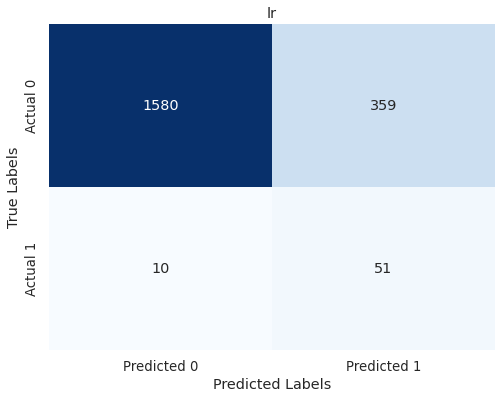

<Figure size 432x288 with 0 Axes>

In [40]:
plot_confusion_matrix("lr",conf)

In [41]:
df = pd.DataFrame()
df["f1_test"] = [f1_test]
df["f1_train"] = f1_train
df["prec_train"] = prec_train
df["prec_test"] = prec_test
df["recall_train"] = recall_train
df["recall_test"] = recall_test
df["model"] = "Logistic Regression"
df["elapsed"] = elapsed

In [42]:
df

,f1_test,f1_train,prec_train,prec_test,recall_train,recall_test,model,elapsed
0,0.216561,0.814545,0.823529,0.12439,0.805755,0.836066,Logistic Regression,0.018198


In [43]:
df.to_csv("../results/regular/lr.csv", index=False)

In [44]:
len(test)

2000